# SSD를 사용한 OD

## Configure

In [5]:
class Config: # hyperparameter 는 task에 맞게 유동적으로 바꿔진 것 같음.
    VOC_ROOT = '/workspace/hakerton/simple-ssd-for-beginners/VOCdevkit'
    num_classes = 7
    resume = None
    lr = 0.0007
    batch_size = 64 
    momentum = 0.9
    weight_decay = 5e-4
    epoch = 100 
    gamma = 0.2
    lr_reduce_epoch = 30
    save_folder = 'weights/'
    basenet = 'vgg16_reducedfc.pth'
    log_fn = 1
    neg_radio = 3
    min_size = 300
    grids = (38, 19, 10, 5, 3, 1)
    aspect_ratios = ((2,), (2, 3), (2, 3), (2, 3), (2,), (2,)) # ratio.
    steps = [s / 300 for s in (8, 16, 32, 64, 100, 300)]
    sizes = [s / 300 for s in (30, 60, 111, 162, 213, 264, 315)] # default box size의 기준.
    anchor_num = [4, 6, 6, 6, 4, 4]
    mean = (104, 117, 123)
    variance = (0.1, 0.2)
opt = Config()

## Utils

In [ ]:


import numpy as np
import torch
import cv2

"""
    cx,cy,h,w (중앙좌표 및 너비 높이) -> x1,y1, x2, y2
"""

def point_form(boxes):

    tl = boxes[:, :2] - boxes[:, 2:]/2
    br = boxes[:, :2] + boxes[:, 2:]/2

    return np.concatenate([tl, br], axis=1)


def detection_collate(batch):

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(sample[1])
    return torch.stack(imgs), np.array(targets)



def bbox_iou(box_a, box_b):

    m = box_a.shape[0]
    n = box_b.shape[0]

    tl = np.maximum(box_a[:, None, :2], box_b[None, :, :2])
    br = np.minimum(box_a[:, None, 2:], box_b[None, :, 2:])

    wh = np.maximum(br-tl, 0)
    
    inner = wh[:, :, 0]*wh[:, :, 1]

    a = box_a[:, 2:] - box_a[:, :2]
    b = box_b[:, 2:] - box_b[:, :2]

    a = a[:, 0] * a[:, 1]
    b = b[:, 0] * b[:, 1]

    a = a[:, None]
    b = b[None, :]

    return inner / (a+b-inner)


def nms(boxes, score, threshold=0.4):

    sort_ids = np.argsort(score)
    pick = []
    while len(sort_ids) > 0:
        i = sort_ids[-1]
        pick.append(i)
        if len(sort_ids) == 1:
            break

        sort_ids = sort_ids[:-1]
        box = boxes[i].reshape(1, 4)
        ious = bbox_iou(box, boxes[sort_ids]).reshape(-1)

        sort_ids = np.delete(sort_ids, np.where(ious > threshold)[0])

    return pick



"""
    nms 기반으로 detect
"""
def detect(locations, scores, nms_threshold, gt_threshold):

    scores = scores[:, 1:] 

    keep_boxes = []
    keep_confs = []
    keep_labels = []

    for i in range(scores.shape[1]):

        mask = scores[:, i] >= gt_threshold
        label_scores = scores[mask, i] 
        label_boxes = locations[mask]

        if len(label_scores) == 0:
            continue

        pick = nms(label_boxes, label_scores, threshold=nms_threshold)
        label_scores = label_scores[pick]
        label_boxes = label_boxes[pick]
        

        keep_boxes.append(label_boxes.reshape(-1))
        keep_confs.append(label_scores)
        keep_labels.extend([i]*len(label_scores))

    if len(keep_boxes) == 0:
        return np.array([]), np.array([]), np.array([])
        
    
    keep_boxes = np.concatenate(keep_boxes, axis=0).reshape(-1, 4)

    keep_confs = np.concatenate(keep_confs, axis=0)
    keep_labels = np.array(keep_labels).reshape(-1)

    return keep_boxes, keep_confs, keep_labels




# draw rectangle
def draw_rectangle(src_img, labels, conf, locations, label_map):

    num_obj = len(labels)
    COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    img = src_img.copy()
    for i in range(num_obj):
        tl = tuple(locations[i][:2])
        br = tuple(locations[i][2:])
        
        cv2.rectangle(img,
                      tl,
                      br,
                      COLORS[i%3], 3)
        cv2.putText(img, label_map[labels[i]], tl,
                    FONT, 1, (255, 255, 255), 2)
    
    img = img[:, :, ::-1]

    return img

## Model (SSD)
### SSD는 backbone model에서부터 그 후 추가적인 conv layers들에서 여러번 prediction을 진행합니다. (default : backbone에서 2번, extra에서 4번)
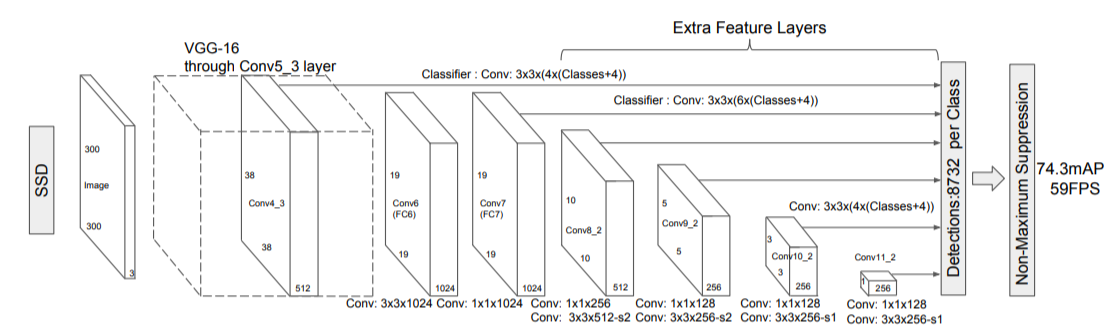

In [ ]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import models
import torch.nn.functional as F
import torch.nn.init as init



class L2Norm(nn.Module): # model에서의 L2Norm 사용

    def __init__(self, n_channels, scale):
        super(L2Norm, self).__init__()
        self.n_channels = n_channels
        self.gamma = scale or None
        self.eps = 1e-10
        self.weight = nn.Parameter(torch.Tensor(self.n_channels))
        self.reset_parameters()

    def reset_parameters(self):
        init.constant_(self.weight, self.gamma)
        

    def forward(self, x):
        norm = torch.sqrt(x.pow(2).sum(dim=1, keepdim=True)) + self.eps # L2 Norm + 1e-10 (0 으로 나누지 않기 위해)
        x = torch.div(x, norm) # x/norm, L2 Norm을 기준으로 Normalization
        x = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x) * x # (1,n_channels, 1, 1) -> (BS, n_channels, H, W)weight를로 바꿔줌
        return x

"""
    VGG에서 추가적인 예측을 진행해야하기 때문에 list로 저장해줍니다.
"""

def VGG():
    base_vgg = models.vgg16().features # MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    base_vgg[16].ceil_mode = True # ceilmode 수정
    vgg = []
    for i in range(30): # 마지막 maxpool 제외하고 가져오기
        vgg.append(base_vgg[i])

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    vgg += [pool5, conv6,nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return vgg

"""
    본 코드에서는 짝수 레이어를 예측에 사용합니다.    
"""

def Extra():
    layers = []
    conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1)
    conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
    conv9_1 = nn.Conv2d(512, 128, kernel_size=1, stride=1)
    conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
    conv10_1 = nn.Conv2d(256, 128, kernel_size=1, stride=1)
    conv10_2 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
    conv11_1 = nn.Conv2d(256, 128, kernel_size=1)
    conv11_2 = nn.Conv2d(128, 256, kernel_size=3, stride=1)

    layers = [conv8_1, conv8_2, conv9_1, conv9_2, conv10_1, conv10_2, conv11_1, conv11_2]

    return layers

"""
    예측에 사용되는 레이어들을 지정해줍시다.
    이 때 bboxes[k]가 의미하는 바는 default box의 ratio에 따른 예측의 갯수 입니다. (ratio에 대해 두가지를 고려한다면, 원래의 default box, ratio당 가로 세로 고려 한 것, 1:1 좀 더 큰 박스, 이렇게 6개가 존재하게 됩니다.)
"""

def Feature_extractor(vgg, extral, bboxes, num_classes):

    loc_layers = []
    conf_layers = []
    vgg_useful = [21, 33] # 사용할 vgg conv 선택. 21 : 중간의 512-512 conv, 33 : 가장 마지막 1024-1024 conv
    
    for k, v in enumerate(vgg_useful):
        loc_layers += [nn.Conv2d(vgg[v].out_channels, # 512, 1024 -> 38, 19 (이미지 사이즈가 300일 겅우임.)
                                 bboxes[k] * 4, kernel_size=3, padding=1)]  #  anchor * 4개의 값을 갖게 하기 위해서(좌표) -> bounding box의 개수 * 4
        conf_layers += [nn.Conv2d(vgg[v].out_channels,
                        bboxes[k] * num_classes, kernel_size=3, padding=1)] # class에 대한 정보들(num_classes) -> bounding box의 개수 * num_classes

    for k, v in enumerate(extral[1::2], 2): #conv 짝수만 사용. 시작 인덱스 2. 위에서 0, 1번재 가져옴
        loc_layers += [nn.Conv2d(v.out_channels, bboxes[k] # 512, 256, 256, 256 -> 10, 5, 3, 1 (feature map)
                                 * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(v.out_channels, bboxes[k]
                                  * num_classes, kernel_size=3, padding=1)]
        
    
    
    return loc_layers, conf_layers 


"""
    위 메서드 들을 사용해서 SSD model을 선언.
"""

class SSD(nn.Module):

    def __init__(self, num_classes, bboxes):
        super(SSD, self).__init__()

        self.num_classes = num_classes
        self.bboxes = bboxes 

        self.vgg_list = VGG()
        self.extra_list = Extra()

        self.loc_layers_list, self.conf_layers_list = Feature_extractor(self.vgg_list, self.extra_list, self.bboxes, self.num_classes)

        self.L2Norm = L2Norm(512, 20)


        self.vgg = nn.ModuleList(self.vgg_list)
        self.extras = nn.ModuleList(self.extra_list)
        self.loc = nn.ModuleList(self.loc_layers_list)
        self.conf = nn.ModuleList(self.conf_layers_list)


    """
        SSD는 기본적으로 여러 피쳐 정보에서부터 bbox, class를 예측한다.
        feature map의 크기가 크다면 작은 객체를 탐지하기 용이하고, feature map의 크기가 작으면 큰 객체를 탐지하기 용이하다고 한다.
    """
    
    def forward(self, x):

        source = []
        loc = []
        conf = []

        vgg_source = [22, 34] # vgg에서 source로 가져올 것들.
        for i, v in enumerate(self.vgg):
            x = v(x)

            if i in vgg_source:
                if i == 22: # vgg source로 사용할 것이라면 source 에 포함.
                    s = self.L2Norm(x)
                else:
                    s = x
                source.append(s)

        for i, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if i % 2 == 1: #짝수 레이어들 사용한다고 했으니 output source에 넣어주자. 이미지 데이터 자체가 크기때문에 많은 레이어를 사용하는 것 같다.
                source.append(x)


        for s, l, c in zip(source, self.loc, self.conf): # source (BS, C, H, W)
            # 내가 loc layer로 쓰려는 것들. source를 내놓은 layer의 output channel을 이 conv의 input channel과 같게 설정. 그리고 bbox 갯수에 맞게 n*4를 내놓음
            loc.append(l(s).permute(0, 2, 3, 1).contiguous()) # source_n*(BS, H, W, C)
            # 내가 conf layer로 쓰려는 것들. source를 내놓은 layer의 output channel을 이 conv의 input channel과 같게 설정. 그리고 num classes에 맞게 n*num_classes를 내놓음
            conf.append(c(s).permute(0, 2, 3, 1).contiguous()) # source_n*(BS, H, W, C)
        # source_n -> 6개. 6번예측함.
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1) # source_n*(BS,H,W,4*n) -> source_n*(BS,H*W*4n) -> (BS,sourc_n*H*HH4n) ex) 6*10*10*4*n
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1) # ..

        loc = loc.view(loc.size(0), -1, 4) # BS, 6*H*W, 4n 이미지에서 source에 대한 여러 이미지 예측. 4n
        conf = conf.view(conf.size(0), -1, self.num_classes)

        return loc, conf



if __name__ == '__main__':

    x = torch.randn(1, 3, 300, 300)
    ssd = SSD(21, [4,6,6,6,4,4])

    y = ssd(x)
    print(y[0].shape, y[1].shape)


## Multibox Encoder (Matching)
### SSD 는 scaling [0,1] 된 default box를 토대로 offset을 적용하여 예측합니다.
### 이를위해 default box를 생성하고 data를 훈련에 적합한 상태로 만들며 이를 다시 원래 상태로 되돌려 놓는 것이 필요합니다.
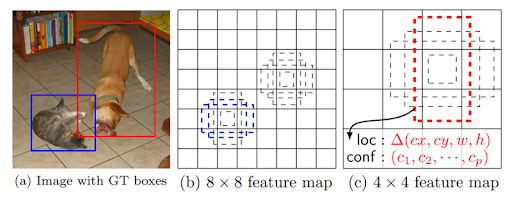

In [ ]:
import itertools
import numpy as np

class MultiBoxEncoder(object):

    def __init__(self, opt):
        self.variance = opt.variance # (0.1, 0.2)

        default_boxes = list()
        for k in range(len(opt.grids)):

            for v, u in itertools.product(range(opt.grids[k]), repeat=2): # range (5) -> 0,0 0,1 0,2 0,3 0,4 ...
                cx = (u + 0.5) * opt.steps[k] # 어떤 feature map에서의 좌표 (x,y)일 때 각 grid 좌표의 center를 (x+0.5, y+0.5)
                cy = (v + 0.5) * opt.steps[k] # 마찬가지. 연산 수행 후 전체 부분으로 표현해주기위해 scaling
                 # cx, cy 최소 최대를 0, 1 사이로 두도록
                s = opt.sizes[k]
                default_boxes.append((cx, cy, s, s))

                s = np.sqrt(opt.sizes[k] * opt.sizes[k + 1]) # ratio가 1일 때 좀 더 큰 박스
                default_boxes.append((cx, cy, s, s)) # 각 좌표에서의 해당 grid 표현 (default box). anchor box와 결이 같은듯.

                s = opt.sizes[k]
                for ar in opt.aspect_ratios[k]: # ratio : s*sqrt(ar), s/sqrt(ar) ...  original, ratio적용 * 2, 1:1
                    default_boxes.append(
                        (cx, cy, s * np.sqrt(ar), s / np.sqrt(ar)))
                    default_boxes.append(
                        (cx, cy, s / np.sqrt(ar), s * np.sqrt(ar))) # ratio에 대해서도 고려. center 좌표에 대한 default boxes를 표현해준다

        default_boxes = np.clip(default_boxes, a_min=0, a_max=1) # 밖으로 벗어나는 친구들은 무시해주자.
        self.default_boxes = np.array(default_boxes) # 디폴트박스 생성 완료!!

    def encode(self, boxes, labels, threshold=0.5): # 내가 생각한 default boxes들과 groud truth 사이의 iou를 파악하고 iou threshold를 넘는 것만 사용하자. (훈련 시에만.)
    # 훈련이 용이하게 ground truth 들을 default boxes들과 매칭 시켜놓자.
        if len(boxes) == 0:
            return (
                np.zeros(self.default_boxes.shape, dtype=np.float32),
                np.zeros(self.default_boxes.shape[:1], dtype=np.int32))

        iou = bbox_iou(point_form(self.default_boxes), boxes) # x1, y1, x2, y2 꼴로 만들어서 bbox_iou 계산하자.

        gt_idx = iou.argmax(axis=1) # iou가 제일 큰거..
        iou = iou.max(axis=1) # 제일 큰 iou
        boxes = boxes[gt_idx]
        labels = labels[gt_idx]

        loc = np.hstack(( # gt 중앙 좌표 / 2 - default box 중앙 좌표 / variance[0] * (default boxes h,w / 2)
            ((boxes[:, :2] + boxes[:, 2:]) / 2 - self.default_boxes[:, :2]) /
            (self.variance[0] * self.default_boxes[:, 2:]),
            np.log((boxes[:, 2:] - boxes[:, :2]) / self.default_boxes[:, 2:]) /
            self.variance[1])) # box h,w / (default box h,w /2) / variance[1]
    # box loss에 들어가는 형태로 encode 시켜줍니다.

        conf = 1 + labels # 0번째 index는 배경이다.
        conf[iou < threshold] = 0 # threshold를 넘지 못하면 background로 가정하자.
       

        return loc.astype(np.float32), conf.astype(np.int32)
 
    def decode(self, loc): # 평가 할 때 box output이 center와 offset으로 나와서 이를 적용해주는 과정. width, height는 log가 씌워진 상태로 prediction이 나오기 때문에 이것도 바꿔줌.

        boxes = np.hstack((
            self.default_boxes[:, :2] + # offset 적용해주기
            loc[:, :2] * self.variance[0] * self.default_boxes[:, 2:],
            self.default_boxes[:, 2:] * np.exp(loc[:, 2:] * self.variance[1])))
        boxes[:, :2] -= boxes[:, 2:] / 2
        boxes[:, 2:] += boxes[:, :2] # 원래의 상태로 되돌려 줌.

        return boxes


if __name__ == '__main__':
    from config import opt
    mb = MultiBoxEncoder(opt)

    print(mb.default_boxes[:10])
    

## SSD Loss
### 아래 사진을 보시면 아시다시피 원래 데이터 형태를 바꿔서 loss에 적용하게 됩니다.
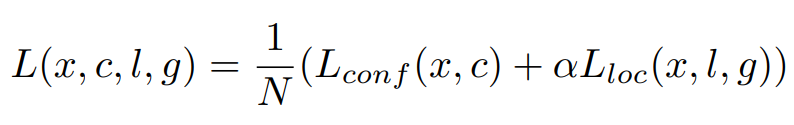
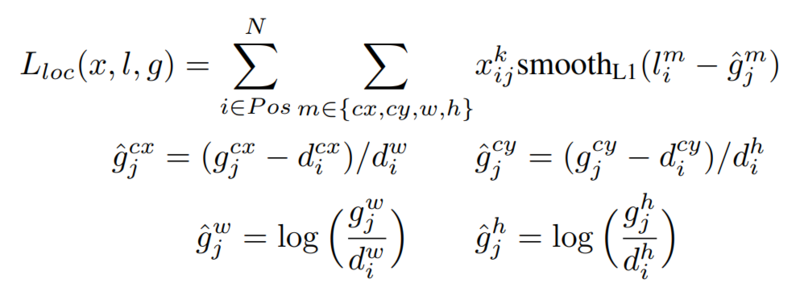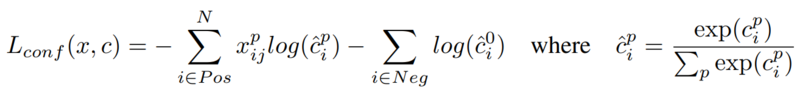

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def hard_negtives(logits, labels, pos, neg_radio): # default box negative : positive = neg_ratio : 1 (3 : 1)

    num_batch, num_anchors, num_classes = logits.shape
    logits = logits.view(-1, num_classes)
    labels = labels.view(-1)

    losses = F.cross_entropy(logits, labels, reduction='none') # Jacovian Matrix loss를 만들어서 hard negative 시행.

    losses = losses.view(num_batch, num_anchors) # batch 갯수, anchor 갯수(image에서 object 수)로 view

    losses[pos] = 0 # Positive (물체가 있는 경우 이 메서드 에서는 positive인 경우는 필요 없다.)

    loss_idx = losses.argsort(1, descending=True) # batch, n 에서 n 기준 sort index 가져오기.
    rank = loss_idx.argsort(1) #(batch, n) # index 를 sorting한 index 가져오기.

    num_pos = pos.long().sum(1, keepdim=True) # positive의 총 개수. (pos는 true false 형태의 (Batch, anchor_num)으로 들어온다.)
    # keepdim True로 했기 때문에 (BS, num_anchors) 형태는 그대로지만 전체 값이 positive의 갯수로 지정된다.
    num_neg = torch.clamp(neg_radio*num_pos, max=pos.shape[1]-1) # positive의 3배. pos shape은 anchor_num을 의미한다. 그니까 예측된 anchor(한 사진에서의 예측한 bb들.)의 수에 맞게 3배로 늘려줌.
    # 만약 positive의 갯수에 3배 한 수가 한 사진에서의 object 예측 수를 넘으면 object 예측 수에 맞춘다.
    neg = rank < num_neg.expand_as(rank) # 마스크 생성. (loss가 높은 것 부터 지정해줌.)
    return neg
    
class MultiBoxLoss(nn.Module):

    def __init__(self, num_classes=7, neg_radio=3):
        super(MultiBoxLoss, self).__init__()
        self.num_classes = num_classes
        self.neg_radio = neg_radio
    
    def forward(self, pred_loc, pred_label, gt_loc, gt_label):
        '''
        pred_loc : (batch, anchor_num, 4)
        pred_label : (batch, anchor_num, num_classes)
        gt_loc : (batch, anchor_num, 4)
        gt_label : (batch, anchor_num)
        '''

        num_batch = pred_loc.shape[0]

        pos_idx = gt_label > 0
        pos_loc_idx = pos_idx.unsqueeze(2).expand_as(pred_loc)
        pred_loc_pos = pred_loc[pos_loc_idx].view(-1, 4)
        gt_loc_pos = gt_loc[pos_loc_idx].view(-1, 4)

        loc_loss = F.smooth_l1_loss(pred_loc_pos, gt_loc_pos, reduction='sum')

        logits = pred_label.detach()
        labels = gt_label.detach()
        neg_idx = hard_negtives(logits, labels, pos_idx, self.neg_radio) #neg (batch, n)

        pos_cls_mask = pos_idx.unsqueeze(2).expand_as(pred_label) # positive와 negative에 대해 mask 생성 (비율을 맞춰주기 위함.)
        neg_cls_mask = neg_idx.unsqueeze(2).expand_as(pred_label)

        conf_p = pred_label[(pos_cls_mask+neg_cls_mask).gt(0)].view(-1, self.num_classes)
        target = gt_label[(pos_idx+neg_idx).gt(0)]

        cls_loss = F.cross_entropy(conf_p, target, reduction='sum')
        N = pos_idx.long().sum()

        loc_loss /= N
        cls_loss /= N


        return loc_loss, cls_loss


## Augmentation

In [ ]:
import cv2
import numpy as np
import random


def _crop(image, boxes, labels):
    height, width, _ = image.shape

    if len(boxes) == 0:
        return image, boxes, labels

    while True:
        mode = random.choice((
            None,
            (0.1, None), # min_iou 선택
            (0.3, None),
            (0.7, None),
            (0.9, None),
            (None, None), # -inf, inf : min_iou, max_iou
        )) # random으로 mode = None, mode = (0.1, None) ... 선택

        if mode is None: # single None 나오면 크롭없이 반환
            return image, boxes, labels

        min_iou, max_iou = mode
        if min_iou is None:
            min_iou = float('-inf')
        if max_iou is None:
            max_iou = float('inf')

        for _ in range(50):
            w = random.randrange(int(0.3 * width), width)
            h = random.randrange(int(0.3 * height), height)

            if h / w < 0.5 or 2 < h / w:
                continue # 이미지 크기의 비율은 2:1, 1:2 가 넘지 않게

            l = random.randrange(width - w)
            t = random.randrange(height - h)
            roi = np.array((l, t, l + w, t + h))

            iou = bbox_iou(boxes, roi[np.newaxis])
            if not (min_iou <= iou.min() and iou.max() <= max_iou):
                continue

            image = image[roi[1]:roi[3], roi[0]:roi[2]]

            centers = (boxes[:, :2] + boxes[:, 2:]) / 2
            mask = np.logical_and(roi[:2] < centers, centers < roi[2:]) \
                     .all(axis=1)
            boxes = boxes[mask].copy()
            labels = labels[mask]

            boxes[:, :2] = np.maximum(boxes[:, :2], roi[:2])
            boxes[:, :2] -= roi[:2]
            boxes[:, 2:] = np.minimum(boxes[:, 2:], roi[2:])
            boxes[:, 2:] -= roi[:2]

            return image, boxes, labels


def _distort(image):
    def _convert(image, alpha=1, beta=0):
        tmp = image.astype(float) * alpha + beta
        tmp[tmp < 0] = 0
        tmp[tmp > 255] = 255
        image[:] = tmp

    image = image.copy()

    if random.randrange(2):
        _convert(image, beta=random.uniform(-32, 32))

    if random.randrange(2):
        _convert(image, alpha=random.uniform(0.5, 1.5))

    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    if random.randrange(2):
        tmp = image[:, :, 0].astype(int) + random.randint(-18, 18)
        tmp %= 180
        image[:, :, 0] = tmp

    if random.randrange(2):
        _convert(image[:, :, 1], alpha=random.uniform(0.5, 1.5))

    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image


def _expand(image, boxes, fill):
    if random.randrange(2):
        return image, boxes

    height, width, depth = image.shape
    ratio = random.uniform(1, 4)
    left = random.randint(0, int(width * ratio) - width)
    top = random.randint(0, int(height * ratio) - height)

    expand_image = np.empty(
        (int(height * ratio), int(width * ratio), depth),
        dtype=image.dtype)
    expand_image[:, :] = fill
    expand_image[top:top + height, left:left + width] = image
    image = expand_image

    boxes = boxes.copy()
    boxes[:, :2] += (left, top)
    boxes[:, 2:] += (left, top)

    return image, boxes


def _mirror(image, boxes):
    _, width, _ = image.shape
    if random.randrange(2):
        image = image[:, ::-1]
        boxes = boxes.copy()
        boxes[:, 0::2] = width - boxes[:, 2::-2]
    return image, boxes


def preproc_for_test(image, insize, mean):
    image = cv2.resize(image, (insize, insize))
    image = image.astype(np.float32)
    image -= mean
    return image.transpose(2, 0 , 1)


def preproc_for_train(image, boxes, labels, insize, mean): # transformation
    if len(boxes) == 0:
        boxes = np.empty((0, 4))

    image, boxes, labels = _crop(image, boxes, labels)
    image = _distort(image)
    image, boxes = _expand(image, boxes, mean)
    image, boxes = _mirror(image, boxes)

    height, width, _ = image.shape
    image = preproc_for_test(image, insize, mean)
    boxes = boxes.copy()
    boxes[:, 0::2] /= width
    boxes[:, 1::2] /= height

    return image, boxes, labels


# Dataset

In [ ]:
import torch
import torch.utils.data as data
import xml.etree.ElementTree as ET
import numpy as np
import glob
import os
import cv2

"""
    bbox 좌표 데이터는 0~ 1사이의 값이다.
"""

PERSON_LABELS = (
        'Person',
        'stroller',
        'blinder',
        'wheelchair',
        'child',
        'merchant',
    )

# UHD (가로: 3840, 세로: 2160) 해상도
"""
    file name 에 대한 List를 가져와서 이를 토대로 img, ano 에 대한 정보 모두를 가져옵니다.
"""

class CCTVDetection(data.Dataset):


    def __init__(self,is_train=True):

        self.is_train = is_train
        self.opt = opt
        self.ids = []
        root = '/content/drive/MyDrive/ImageTrackingStudy'
        if self.is_train:
            img_file = os.path.join(root,'train_img/*')
            ano_file = os.path.join(root,'train_label/*')
            file_list = glob.glob(img_file)
            file_list_img = [file for file in file_list if file.endswith(".jpg")]

            for i in file_list_img:
                # file_name = i[14:-4]
                file_name = os.path.split(i)[1].split('.')[0]
                img = f"{root}/train_img/{file_name}.jpg"
                ano = f"{root}/train_label/{file_name}.txt"
                # ano = os.path.join("dataset/train_label",file_name + '.txt')
                # img = os.path.join("dataset/train_img",file_name + '.jpg')
                
                if os.path.isfile(ano) and os.path.isfile(img):
                    self.ids.append((img, ano))
        else:
            img_file = os.path.join(root,'test_img/*')
            file_list = glob.glob(img_file)
            file_list_img = [file for file in file_list if file.endswith(".jpg")]
            for i in file_list_img:
                self.ids.append((i))
            
            
    def __getitem__(self, index):

        if self.is_train:
            img_path, ano_path = self.ids[index] # img, ano path
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
            boxes, labels = self.get_annotations(ano_path) # txt 파일에서 가져옴.

            if self.is_train:
                image, boxes, labels = preproc_for_train(image, boxes, labels, opt.min_size, opt.mean)
                image = torch.from_numpy(image)

            target = np.concatenate([boxes, labels.reshape(-1,1)], axis=1)

            return image, target
        else:
            img_path = self.ids[index]
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
            return image
        # 이미지 당 여러개의 boxes가 존재하고 이에 대한 여러 labels가 존재한다.
        # 나중에 dataloader를 통해 batch를 형성하게 되면 (BS, N, 4) 이렇게 나온다.
    def get_annotations(self, path):
        
        f = open(path, 'r')
        det = f.readlines()
        boxes = []
        labels = []
        for d in det:
            obj = d.split(' ')
            label = int(obj[0]) # label
            box = [float(obj[1]),float(obj[2]),float(obj[1])+float(obj[3]),float(obj[2])+float(obj[4])] # x1, y1, x2, y2
            boxes.append(box)
            labels.append(label)
        return np.array(boxes), np.array(labels)
            

        

    def __len__(self):
        return len(self.ids)
        


# Train

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import os


# device = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def adjust_learning_rate(optimizer, gamma, step):
    """Sets the learning rate to the initial LR decayed by 10 at every
        specified step
    """

    lr = opt.lr * (gamma ** (step))
    print('change learning rate, now learning rate is :', lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


if __name__ == '__main__':

    print('now runing on device : ', device)
    if not os.path.exists(opt.save_folder):
        os.mkdir(opt.save_folder)
    
    # SSD 모델 선언

    model = SSD(opt.num_classes, opt.anchor_num) 
    # 전에 진행한 적이 있으면 checkpoint가 있는지 확인 해 주자.
    if opt.resume:
        print('loading checkpoint...')
        model.load_state_dict(torch.load(opt.resume))
    else: # 아니면 vgg weights를 pretrain 된 weights를 가져옴.
        vgg_weights = torch.load(opt.save_folder + opt.basenet)
        print('Loading base network...')
        model.vgg.load_state_dict(vgg_weights)

     
    model.to(device)
    model.train()
    # Multibox Encoder
    mb = MultiBoxEncoder(opt)
    # Datset
    dataset = CCTVDetection(True)
    # Data 들의 크기가 너무 커서 (UHD) 불러오는데 시간이 많이 걸리는 것 같다.
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, collate_fn=detection_collate, num_workers=0)
    
    criterion = MultiBoxLoss(opt.num_classes, opt.neg_radio).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=opt.lr, momentum=opt.momentum,
                          weight_decay=opt.weight_decay)

    print('start training........')
    for e in range(opt.epoch):
        if e % opt.lr_reduce_epoch == 0:
            adjust_learning_rate(optimizer, opt.gamma, e//opt.lr_reduce_epoch)
        total_loc_loss = 0
        total_cls_loss = 0
        total_loss = 0
        for i , (img, boxes) in enumerate(dataloader):
            img = img.to(device)
            gt_boxes = []
            gt_labels = []
            for box in boxes:
                labels = box[:, 4]
                box = box[:, :-1]
                # train 형태에 맞게 encode (cx, cy, .. )
                # default box와 미리 매칭 시켜주자. (iou 기준.)
                match_loc, match_label = mb.encode(box, labels)
            
                gt_boxes.append(match_loc)
                gt_labels.append(match_label)
            
            gt_boxes = torch.FloatTensor(gt_boxes).to(device)
            gt_labels = torch.LongTensor(gt_labels).to(device)


            p_loc, p_label = model(img)
            
            loc_loss, cls_loss = criterion(p_loc, p_label, gt_boxes, gt_labels)

            loss = loc_loss + cls_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loc_loss += loc_loss.item()

            total_cls_loss += cls_loss.item()
            total_loss += loss.item()
            if i % opt.log_fn == 0:
                avg_loc = total_loc_loss / (i+1)
                avg_cls = total_cls_loss / (i+1)
                avg_loss = total_loss / (i+1)
                print('epoch[{}] | batch_idx[{}] | loc_loss [{:.2f}] | cls_loss [{:.2f}] | avg_loss [{:.2f}]'.format(e, i, avg_loc, avg_cls, avg_loss))

        if (e+1) % 1 == 0:
            torch.save(model.state_dict(), os.path.join(opt.save_folder, 'loss-{:.2f}.pth'.format(total_loss)))





    VOC_ROOT = '/workspace/hakerton/simple-ssd-for-beginners/VOCdevkit'

    num_classes = 7

    resume = None

    lr = 0.0005

    batch_size = 64 

    momentum = 0.9

    weight_decay = 5e-4

    epoch = 100 

    gamma = 0.2

    lr_reduce_epoch = 30

    save_folder = '/content/drive/MyDrive/ImageTrackingStudy/weights/'

    basenet = 'vgg16_reducedfc.pth'

    log_fn = 1

    neg_radio = 3

    min_size = 300

    grids = (38, 19, 10, 5, 3, 1)

    aspect_ratios = ((2,), (2, 3), (2, 3), (2, 3), (2,), (2,)) # ratio.

    steps = [s / 300 for s in (8, 16, 32, 64, 100, 300)]

    sizes = [s / 300 for s in (30, 60, 111, 162, 213, 264, 315)] # default box size의 기준. np.sqrt(sizes[k] * sizes[k+1])

    anchor_num = [4, 6, 6, 6, 4, 4]

    mean = (104, 117, 123)

    variance = (0.1, 0.2)

opt = Config()

now runing on device :  cuda
Loading base network...
start training........
change learning rate, now learning rate is : 0.0005


/content/lib/utils.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return torch.stack(imgs), np.array(targets)


epoch[0] | batch_idx[0] | loc_loss [3.08] | cls_loss [12.39] | avg_loss [15.47]
epoch[0] | batch_idx[1] | loc_loss [3.06] | cls_loss [11.79] | avg_loss [14.84]
epoch[0] | batch_idx[2] | loc_loss [3.08] | cls_loss [11.22] | avg_loss [14.30]
epoch[0] | batch_idx[3] | loc_loss [2.99] | cls_loss [10.74] | avg_loss [13.73]
epoch[0] | batch_idx[4] | loc_loss [2.95] | cls_loss [10.35] | avg_loss [13.30]
epoch[0] | batch_idx[5] | loc_loss [2.90] | cls_loss [9.96] | avg_loss [12.86]
epoch[0] | batch_idx[6] | loc_loss [2.86] | cls_loss [9.69] | avg_loss [12.55]
epoch[0] | batch_idx[7] | loc_loss [2.84] | cls_loss [9.49] | avg_loss [12.33]
epoch[0] | batch_idx[8] | loc_loss [2.80] | cls_loss [9.30] | avg_loss [12.10]
epoch[0] | batch_idx[9] | loc_loss [2.77] | cls_loss [9.16] | avg_loss [11.93]
epoch[0] | batch_idx[10] | loc_loss [2.75] | cls_loss [9.02] | avg_loss [11.77]
epoch[0] | batch_idx[11] | loc_loss [2.72] | cls_loss [8.90] | avg_loss [11.62]
epoch[0] | batch_idx[12] | loc_loss [2.69] | 

KeyboardInterrupt: ignored

## Evaluation

In [ ]:
import csv
from dataset import CCTVDetection
from dataset import PERSON_LABELS
from config import opt
import numpy as np
from lib.model import SSD
import torch
import torch.nn.functional as F
import os 
from lib.multibox_encoder import MultiBoxEncoder
from lib.ssd_loss import MultiBoxLoss
import cv2
from lib.utils import nms
from lib.augmentations import preproc_for_test
import matplotlib.pyplot as plt
from lib.utils import detect
import tqdm
import os
import argparse

def convert_to_xyxy(imgWidth, imgHeight, xywh):
    px = float(xywh[0])
    py = float(xywh[1])
    pw = float(xywh[2])
    ph = float(xywh[3])
    
    cpx = px + pw/2
    cpy = py + ph/2

    abspx = cpx / imgWidth
    abspy = cpy / imgHeight
    abspw = pw / imgWidth
    absph = ph / imgHeight  

    abspx = 0.999999 if abspx >= 1 else abspx
    abspy = 0.999999 if abspy >= 1 else abspy
    abspw = 0.999999 if abspw >= 1 else abspw
    absph = 0.999999 if absph >= 1 else absph
    abspx = 0.000001 if abspx < 0 else abspx
    abspy = 0.000001 if abspy < 0 else abspy
    abspw = 0.000001 if abspw < 0 else abspw
    absph = 0.000001 if absph < 0 else absph
            
    return abspx, abspy, abspw, absph

parser = argparse.ArgumentParser()

parser.add_argument('--model', 
                    default='',
                    type=str,
                    help='model checkpoint used to eval CCTV dataset')
args = parser.parse_args()

checkpoint = args.model


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if __name__ == '__main__': 
    
    print('using {} to eval, use cpu may take an hour to complete !!'.format(device))
    model = SSD(opt.num_classes, opt.anchor_num)
    
    print('loading checkpoint from {}'.format(checkpoint))
    state_dict = torch.load(checkpoint, map_location=None if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(state_dict)
    model.to(device)
    print('model loaded')
    
    multibox_encoder = MultiBoxEncoder(opt)
    test_dataset = CCTVDetection(False)

    print('start detect.........')
    
    f = open('pred.csv','w', newline='')
    wr = csv.writer(f)
    wr.writerow(["ImageID","LabelName","Conf","XMin","XMax","YMin","YMax"])
    
    for i in tqdm.tqdm(range(len(test_dataset))):

        src = test_dataset[i]
        img_name = os.path.basename(test_dataset.ids[i][19:-4])
        image = preproc_for_test(src, opt.min_size, opt.mean)
        image = torch.from_numpy(image).to(device)
        with torch.no_grad():
            loc, conf = model(image.unsqueeze(0))
        loc = loc[0]
        conf = conf[0]
        conf = F.softmax(conf, dim=1)
        conf = conf.cpu().numpy()
        loc = loc.cpu().numpy()

        decode_loc = multibox_encoder.decode(loc)
        gt_boxes, gt_confs, gt_labels = detect(decode_loc, conf, nms_threshold=0.5, gt_threshold=0.5)

        #no object detected
        if len(gt_boxes) == 0:
            continue

        h, w = src.shape[:2]
        gt_boxes[:, 0] = gt_boxes[:, 0] * w
        gt_boxes[:, 1] = gt_boxes[:, 1] * h
        gt_boxes[:, 2] = gt_boxes[:, 2] * w
        gt_boxes[:, 3] = gt_boxes[:, 3] * h
        
        for box, label, score in zip(gt_boxes, gt_labels, gt_confs):
            box[0],box[1],box[2],box[3] = convert_to_xyxy(w,h,[box[0],box[1],box[2],box[3]])
            wr.writerow([img_name,list(PERSON_LABELS)[label],"{:.3f}".format(score),"{:.8f}".format(box[0]),"{:.8f}".format(box[1]),"{:.8f}".format(box[2]),"{:.8f}".format(box[3])])

    
    f.close()


In [8]:
import torch

pos = torch.ones((32,10))
num_pos = pos.long().sum(1, keepdim=True)
num_neg = torch.clamp(3*num_pos, max=pos.shape[1]-1) #(batch, 1)

In [10]:
num_pos

tensor([[10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10]])